## 机器翻译作业

本次作业使用 seq2seq模型完成英文到中文的机器翻译任务，请补充缺失部分的代码

In [1]:
#导入常用软件包
import torch
import sys
from torch import nn, optim
import random
from torch.nn.functional import softmax
import re
import os

from torchtext import data
from torchtext.data import Iterator, BucketIterator
from collections import defaultdict
import string
import dill

## 1.数据加载

数据：包含六个文件：
1. 训练集：train.seg.en.txt train.seg.zh.txt （11743条）
2. 验证集：dev.seg.en.txt dev.seg.zh.txt （2936条）
3. 测试集：test.seg.en.txt test.seg.zh.txt （5194条）

使用torchtext完成数据的加载，主要使用以下三个组件：

1. Field :主要包含以下数据预处理的配置信息，比如指定分词方法，是否转成小写，起始字符，结束字符，补全字符以及词典等等

2. Dataset :继承自pytorch的Dataset，用于加载数据，提供了TabularDataset可以指点路径，格式，Field信息就可以方便的完成数据加载。同时torchtext还提供预先构建的常用数据集的Dataset对象，可以直接加载使用，splits方法可以同时加载训练集，验证集和测试集。

3. Iterator : 主要是数据输出的模型的迭代器，可以支持batch定制

具体可以参照：https://pytorch.org/text/stable/index.html

In [12]:
class Dataloader:
    def __init__(self, batch_size, device, eval=False):
        raw_data = self.read_data("./data/", test=eval)
        ## 训练模式
        if not eval:
            train_data, dev_data = raw_data
            ##定义数据字段
            self.id_field = data.Field(sequential=False, use_vocab=False)
            self.en_field = data.Field(init_token='<sos>', eos_token='<eos>', lower=True, include_lengths=True)
            self.zh_field = data.Field(init_token='<sos>', eos_token='<eos>', lower=True)
            self.fields = [("id", self.id_field), ("en", self.en_field), ("zh", self.zh_field)]

            ##构建数据集
            train_dataset = data.Dataset([data.Example.fromlist([idx, item[0], item[1]], self.fields) for idx, item in enumerate(train_data)], self.fields)
            dev_dataset =  data.Dataset([data.Example.fromlist([idx, item[0], item[1]], self.fields) for idx, item in enumerate(dev_data)], self.fields)
            
            ##构建数据迭代器
            self.train_iterator= BucketIterator(train_dataset, batch_size=batch_size, device=device, sort_key=lambda x: len(x.en), sort_within_batch=True)
            self.dev_iterator= BucketIterator(dev_dataset, batch_size=batch_size, device=device, sort_key=lambda x: len(x.en), sort_within_batch=True)
            
            ##构建词典
            self.en_field.build_vocab(train_dataset, min_freq=2)
            self.zh_field.build_vocab(train_dataset, min_freq=2)
            
            ##存储字段
            dill.dump(self.en_field, open("./model/EN.Field", "wb"))
            dill.dump(self.zh_field, open("./model/ZH.Field", "wb"))

            print("en vocab size:", len(self.en_field.vocab.itos),"zh vocab size:", len(self.zh_field.vocab.itos))
        
        ## 测试模式  
        else:
            test_data = raw_data[-1]
            ##加载存储的字段
            self.id_field = data.Field(sequential=False, use_vocab=False)
            self.en_field = dill.load(open("./model/EN.Field", "rb"))
            self.zh_field = dill.load(open("./model/ZH.Field", "rb"))
            self.fields = [("id", self.id_field), ("en", self.en_field), ("zh", self.zh_field)]
            
            ##构建测试集 & 迭代器
            test_data = data.Dataset([data.Example.fromlist([idx, item[0], item[1]], self.fields) for idx, item in enumerate(test_data)], self.fields)
            self.test_iterator= BucketIterator(test_data, batch_size=batch_size, device=device, train = False, sort_key=lambda x: len(x.en), sort_within_batch = True)   
        
    ##从文件中读取数据
    def read_data(self, path, test=True, lang1='en', lang2 = 'zh'):
        data = []
        types = ['test'] if test else ['train', 'dev']
        # print(types)
        for type in types:
            sub_data = []
            with open(f"{path}/{type}.seg.{lang1}.txt") as f1, open(f"{path}/{type}.seg.{lang2}.txt") as f2:
                for src, trg in zip(f1, f2):
                    if len(src) > MAX_LEN and len(trg) > MAX_LEN:
                        continue
                    sub_data.append((src.strip(), trg.strip()))
            data.append(sub_data)

        return data


## 2.模型构建
使用seq2seq模型完成机器翻译模型的搭建,可以参考 pytorch tutorials https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

这里需要完成的是一个seq2seq+attention的基础模型，有余力的可以进行更多的尝试
相关的论文：
1. attention:https://arxiv.org/abs/1409.0473
2. copy:https://arxiv.org/abs/1603.06393
3. coverage:https://arxiv.org/abs/1601.04811

### 2.1 Encoder
这里为了简化代码，embedding_size和hidden_size使用相同大小，均为传入的hid_dim

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.vocab_size = input_dim
        ##构建embedding
        self.embedding = nn.Embedding(input_dim, emb_dim)
        ##构建rnn模块
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        ## dropout层
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
    def forward(self, src_info):
        src, src_len = src_info
       
        ## 1. 请补充embedding层（+dropout）代码
        embedded = self.dropout(self.embedding(src)* (self.vocab_size ** 0.5))
        ## 2. 请补充rnn层代码
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)))
        
        return outputs, hidden

### 2.2 Attention模块
Attention 机制的 Encoder-Decoder 模型则是要从序列中学习到每一个元素的重要程度，然后按重要程度将元素合并。因此，注意力机制可以看作是 Encoder 和 Decoder 之间的接口，它向 Decoder 提供来自每个 Encoder 隐藏状态的信息。通过该设置，模型能够选择性地关注输入序列的有用部分，从而学习它们之间的“对齐”。这就表明，在 Encoder 将输入的序列元素进行编码时，得到的不在是一个固定的语义编码 C ，而是存在多个语义编码，且不同的语义编码由不同的序列元素以不同的权重参数组合而成。

在 Attention 机制下，语义编码 C 是各个元素按其重要程度加权求和得到的，即：

$C_i=\sum_{i=1}^{n}{a}_{ij}*{h_i}$

参数 𝑖 表示时刻， 𝑗 表示序列中的第 𝑗 个元素， 𝑇𝑥 表示序列的长度， 𝑓(⋅) 表示对元素 𝑥𝑗 的编码。𝑎𝑖𝑗 可以看作是一个概率，反映了元素 ℎ𝑗 对 𝐶𝑖 的重要性，可以使用 softmax 来表示：

${a}_{ij}= \frac{exp(e_{ij})}{\sum_{k=1}^{T_x}exp(e_{ik})}$

where $e_{ij}=a(s_{i-1}, h_j)$

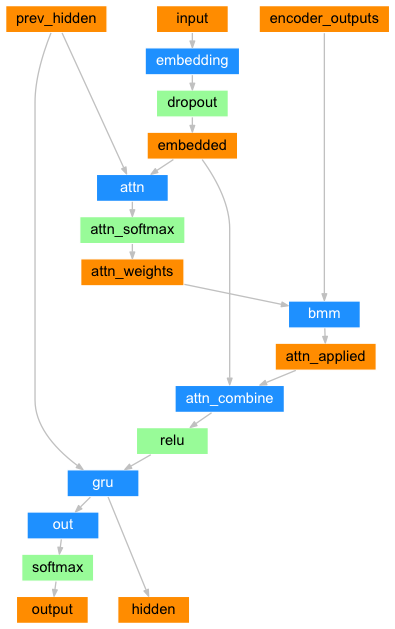

In [15]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))

    def forward(self, hidden, encoder_outputs, mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #将decoder的隐状态重复src_len次
#         print("in attention, hidden shape:", hidden.shape)
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        ##3.请补充计算attention score的代码
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        attention = torch.bmm(v, energy).squeeze(1)
     
        ##mask掉padding部分
        attention = attention.masked_fill(mask == 0, -1e10)
        return softmax(attention, dim=1)

### 2.3 Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim,emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):
        # input = [batch_size]
        # hidden = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_sent_len, batch_size, enc_hid_dim * 2]
        
        ##embedding层
        input = input.unsqueeze(0)  # [1, batch_size]
        embedded = self.dropout(self.embedding(input))  # [1, batch_size, emb_dim]
        
        ##计算attention score
        a = self.attention(hidden, encoder_outputs, mask)  # [batch_size, src_len]
        a = a.unsqueeze(1)  # [batch_size, 1, src_len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        ##4.根据attention score计算weighted的context向量
        weighted = torch.bmm(a, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)#weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        embedded, output, weighted  = embedded.squeeze(0), output.squeeze(0), weighted.squeeze(0)
    
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        return output, hidden.squeeze(0), a


## 2.4 Seq2seq模型

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_idx):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

    def forward(self, src_info, trg = None, teacher_forcing_ratio=0.5):

        src, src_len = src_info
        batch_size = src.shape[1]
        max_len = trg.shape[0] if trg is not None else MAX_LEN
        trg_vocab_size = self.decoder.output_dim
        
        ##存储所有decoder输出的结果
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        attn_scores = []
        
        ## encoder
        encoder_outputs, hidden = self.encoder(src_info)
#         print("encoder outputs shape:", encoder_outputs.shape)
        ##初始化decoder的输入是<sos>token
        input = trg[0, :] if trg is not None else src[0, :]
        #mask = [batch size, src len]
        mask = self.create_mask(src)
#         print("mask shape:", mask.shape)
        
        ## decode过程，每个step decode出一个token 
        for t in range(1, max_len):
            ## 5.请补全decoder的代码，得到output, hidden, atten_score
            output, hidden, attn_score = self.decoder(input, hidden, encoder_outputs, mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
            attn_scores.append(attn_score)
        return outputs, torch.cat(attn_scores, dim = 1).to(self.device)

    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask

## 3.训练模块代码
包括BLEU的计算

train_iter的代码

evaluate_iter的代码（在验证集上）


In [5]:
## bleu计算
import jieba
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu(hypothesis, targets, cut=True, verbose=False):
    bleu_scores = []
    for sent, trg in zip(hypothesis, targets):
        trg = trg.strip().lower().split()
        sent = sent.strip()
        if cut:
            trg = list(jieba.cut(''.join(trg).replace("-", "")))
            sent = list(jieba.cut(''.join(sent).replace("-", "")))
 
        bleu = sentence_bleu([trg], sent, weights=(0.5, 0.5, 0., 0.),smoothing_function = SmoothingFunction().method1)
        if verbose:
            print(f"src:{sent.strip()}\ntrg:{trg}\npredict:{sent}\n{bleu}\n")
        bleu_scores.append(bleu)         
    return sum(bleu_scores) / len(bleu_scores)

In [6]:
def train_iter(model, iterator, optimizer, criterion, clip, nl_field = None):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src, src_len = batch.en
        trg = batch.zh
        optimizer.zero_grad()
        
        output, _ = model((src, src_len), trg, 0.5)
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [7]:
def evaluate_iter(model, iterator, en_field, zh_field, criterion):
    model.eval()

    hypothesis, targets = [], []
    eval_loss = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            src, src_len = batch.en
#             print("src shape:", src.shape)
            trg = batch.zh
            output, _ = model((src, src_len), trg, 0)  # turn off teacher forcing
            trg_sent_len, batch_size, output_dim = output.shape[0], output.shape[1], output.shape[2]
            
            loss = criterion(output[1:].view(-1, output.shape[-1]), trg[1:].view(-1))
            eval_loss += loss.item()
            ##解码每个句子，greedy search，可以改进为beam search
            for sent in range(batch_size):
                eos_index = [x.item() for x in src[:, sent]].index(en_field.vocab.stoi['<eos>'])
                src_str = ' '.join([en_field.vocab.itos[x.item()] for x in src[1: eos_index, sent]])
                predicts = [] 
                for i in range(1, trg_sent_len):
                    predict = zh_field.vocab.itos[output[i][sent].topk(1)[1].item()]
                    if predict != '<eos>' and predict != '<pad>':
                        predicts.append(predict)
                    else:
                        break
                grounds = []
                for i in range(1, trg_sent_len):
                    ground = zh_field.vocab.itos[trg[i][sent].item()]
                    if ground != '<eos>' and ground != '<pad>':
                        grounds.append(ground)
                    else:
                        break
                hypothesis.append(' '.join(predicts))
                targets.append(' '.join(grounds))

    bleu = calculate_bleu(hypothesis, targets)  

    return bleu, eval_loss / len(iterator)

In [8]:
def inference(model, iterator, en_field, zh_field):
    model.eval()

    with torch.no_grad():
        predict_res = []
        for _, batch in enumerate(iterator):
            src, src_len = batch.en
            id, trg = batch.id, batch.zh
            output, _ = model((src, src_len), teacher_forcing_ratio = 0)  # turn off teacher forcing
            trg_sent_len, batch_size, output_dim = output.shape[0], output.shape[1], output.shape[2]
            
            for sent in range(batch_size):
                if en_field is not None:
                    eos_index = [x.item() for x in src[:, sent]].index(en_field.vocab.stoi['<eos>'])
                    src_str = ' '.join([en_field.vocab.itos[x.item()] for x in src[1: eos_index, sent]])
                    sent_id = id[sent]
                predicts = []
                for i in range(1, trg_sent_len):
                    predict = zh_field.vocab.itos[output[i][sent].topk(1)[1].item()]
             
                    if predict != '<eos>' and predict != '<pad>':
                        predicts.append(predict)
                    else:
                        break
                grounds = []
                for i in range(1, trg_sent_len):
                    ground = zh_field.vocab.itos[trg[i][sent].item()]
                    if ground != '<eos>' and ground != '<pad>':
                        grounds.append(ground)
                    else:
                        break
  
                predict_res.append((int(sent_id), src_str, ' '.join(predicts), " ".join(grounds)))

    predict_res = [(item[1],item[2], item[3] ) for item in sorted(predict_res, key=lambda x: x[0])]

    bleu = calculate_bleu([i[1] for i in predict_res], [i[2] for i in predict_res])
    return bleu, predict_res

## 训练模型

In [9]:
def train(dataloader, model, model_output_path):

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=dataloader.zh_field.vocab.stoi['<pad>'])
    train_iterator, dev_iterator = dataloader.train_iterator, dataloader.dev_iterator

    bleu, eval_loss= evaluate_iter(model, dev_iterator, dataloader.en_field, dataloader.zh_field, criterion)
    
    best_bleu, best_loss = bleu, eval_loss
    torch.save(model, model_output_path +'model_best.pt')
    
    for epoch in range(N_EPOCHS):
        loss = train_iter(model, train_iterator, optimizer, criterion, CLIP, nl_field = dataloader.en_field)
   
        if epoch %5 == 0:
            torch.save(model, model_output_path +f'model_{epoch}.pt')
        bleu, loss = evaluate_iter(model, dev_iterator, dataloader.en_field, dataloader.zh_field, criterion)
        if  loss < best_loss:
            best_bleu = bleu
            best_loss = loss
            torch.save(model, model_output_path +'model_best.pt')
        
        print(f'Best BLEU: {best_bleu:.3f} | Best Loss:{best_loss:.3f} |  Epoch: {epoch:d} |  BLeu： {bleu:.3f} | Loss:{loss}', flush=True)


In [10]:
## 参数设定(可以自己修改)
MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
INFERENCE_BATCH_SIZE = 64
HID_DIM = 256
DROPOUT=0.2
N_EPOCHS = 100
CLIP = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH='./model/'

In [17]:
##定义各个模块
dataloader = Dataloader(TRAIN_BATCH_SIZE, device)
attn = Attention(HID_DIM, HID_DIM)
INPUT_DIM = len(dataloader.en_field.vocab)
OUTPUT_DIM = len(dataloader.zh_field.vocab)
encoder = Encoder(INPUT_DIM, HID_DIM, HID_DIM, HID_DIM, DROPOUT)
decoder = Decoder(OUTPUT_DIM, HID_DIM, HID_DIM, HID_DIM, DROPOUT, attn)
model = Seq2Seq(encoder, decoder, device, dataloader.zh_field.vocab.stoi['<pad>']).to(device)
train(dataloader, model, model_output_path= MODEL_PATH)

en vocab size: 6182 zh vocab size: 4836


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/vx/4c6x6vhd5k9_7cv3dp397mrm0000gp/T/jieba.cache
Loading model cost 1.108 seconds.
Prefix dict has been built successfully.
/Users/Amcute/anaconda3/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Seq2Seq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/Amcute/anaconda3/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/Amcute/anaconda3/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/Amcute/a

TypeError: evaluate_iter() missing 1 required positional argument: 'criterion'

## 推理部分

In [ ]:
def inference(model, iterator, en_field, zh_field):
    model.eval()

    with torch.no_grad():
        predict_res = []
        for _, batch in enumerate(iterator):
            src, src_len = batch.en
            id, trg = batch.id, batch.zh
            output, _ = model((src, src_len), teacher_forcing_ratio = 0)  # turn off teacher forcing
            trg_sent_len, batch_size, output_dim = output.shape[0], output.shape[1], output.shape[2]
            
            for sent in range(batch_size):
                if en_field is not None:
                    eos_index = [x.item() for x in src[:, sent]].index(en_field.vocab.stoi['<eos>'])
                    src_str = ' '.join([en_field.vocab.itos[x.item()] for x in src[1: eos_index, sent]])
                    sent_id = id[sent]
                predicts = []
                for i in range(1, trg_sent_len):
                    predict = zh_field.vocab.itos[output[i][sent].topk(1)[1].item()]
             
                    if predict != '<eos>' and predict != '<pad>':
                        predicts.append(predict)
                    else:
                        break
                grounds = []
                for i in range(1, trg_sent_len):
                    ground = zh_field.vocab.itos[trg[i][sent].item()]
                    if ground != '<eos>' and ground != '<pad>':
                        grounds.append(ground)
                    else:
                        break
  
                predict_res.append((int(sent_id), src_str, ' '.join(predicts), " ".join(grounds)))

    predict_res = [(item[1],item[2], item[3] ) for item in sorted(predict_res, key=lambda x: x[0])]

    bleu = calculate_bleu([i[1] for i in predict_res], [i[2] for i in predict_res])
    return bleu, predict_res

In [ ]:
dataloader = dataloader(INFERENCE_BATCH_SIZE, device, eval=True)
model_init_path = f"{MODEL_PATH}/model_best.pt"
model = torch.load(model_init_path)
bleu, predict_output = inference(model, dataloader.test_iterator, dataloader.en_field, dataloader.zh_field)
for item in predict_output:
    src, trg, golden = item
    print(f"src:{src}\ntrg:{trg}\ngolden:{golden}\n")
print(bleu)